<h2>Exercise 1- Box Detection <br /></h2>
<h3>Authors: Melih Hasbi Ekinci and Prem Prakash Singh<br /></h3>

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D

<h4>1- Loading Data <br /></42>

In [2]:
data = loadmat('example1kinect.mat')
amplitude_image = data['amplitudes1']
distance_image = data['distances1']
point_cloud = data['cloud1']

<h4>2- RANSAC and Helper Functions Implementation  <br /></42>

In [20]:
def RANSAC_plane_fit(point_cloud, threshold, max_iterations):
    best_inliers = []
    best_plane = None

    valid_points = point_cloud[point_cloud[:, 2] != 0]  # Filter out invalid measurements

    for _ in range(max_iterations):
        # Randomly sample three points
        sample_points = valid_points[np.random.choice(valid_points.shape[0], 3, replace=False)]

        # Calculate plane parameters using cross product
        normal = np.cross(sample_points[1] - sample_points[0], sample_points[2] - sample_points[0])
        d = -np.dot(normal, sample_points[0])

        # Compute the distance of all points to the plane
        distances = np.abs(np.matmul(valid_points, normal) + d) / np.linalg.norm(normal)

        # Find inliers
        inliers = valid_points[np.where(distances < threshold)]

        # Check if this model is better
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_plane = (normal, d)

    return best_plane, best_inliers

def create_mask(point_cloud, inliers):
    reshaped_pc = point_cloud.reshape(-1, 3)
    mask = np.isin(reshaped_pc, inliers).all(axis=1).reshape(point_cloud.shape[0], point_cloud.shape[1])
    return mask
   

def extract_largest_component(mask):
    labeled_mask, num_features = ndimage.label(mask)
    component_sizes = ndimage.sum(mask, labeled_mask, range(num_features + 1))
    largest_component_label = component_sizes.argmax()
    return (labeled_mask == largest_component_label)

def visualize_mask(mask,cmap):
    plt.imshow(mask, cmap=cmap)
    plt.show()

def get_first_mask(threshold,max_iterations,point_cloud):
    # RANSAC parameters
    threshold = threshold  
    max_iterations = max_iterations 
    best_plane, inliers = RANSAC_plane_fit(point_cloud.reshape(-1,3), threshold, max_iterations)
    return best_plane,inliers

def get_second_mask(mask,point_cloud,threshold,max_iterations):
    nonfloor_cloud = np.stack(((1-mask)*point_cloud[:,:,0], (1-mask)*point_cloud[:,:,1], (1-mask)*point_cloud[:,:,2]), axis=-1)
    # RANSAC parameters
    threshold =threshold  
    max_iterations = max_iterations  
    best_plane_second, inliers_second = RANSAC_plane_fit(nonfloor_cloud.reshape(-1,3), threshold, max_iterations)
    # Now visualize the inliers (floor mask)
    mask_second=create_mask(nonfloor_cloud, inliers_second)
    # Clean up the mask using binary morphological operations
    cleaned_mask = ndimage.binary_opening(ndimage.binary_closing(mask_second))
    # Extract the largest connected component
    largest_component = extract_largest_component(cleaned_mask) 
    return largest_component, best_plane_second

def find_corners(mask):
    # Find contours
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour corresponds to the box top
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Approximate a polygon and get vertices
    epsilon = 0.1 * cv2.arcLength(largest_contour, True)
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    return corners


def calculate_dimensions(corners):
    # Convert corners to convenient format
    corners = [corner[0] for corner in corners]
    # Calculate pairwise distances
    distances = [np.linalg.norm(np.array(corner1) - np.array(corner2)) for i, corner1 in enumerate(corners) for j, corner2 in enumerate(corners) if i < j]
    # Get the largest two distances
    width= np.average(sorted(list(set(distances)))[0:2])
    length= np.average(sorted(list(set(distances)))[2:4])
    return length, width, distances

def compute_distance_between_planes(best_plane,best_plane_second):
    """
    Compute the distance between two parallel planes.
    :param a1, b1, c1, d1: coefficients of the first plane's equation
    :param a2, b2, c2, d2: coefficients of the second plane's equation
    :return: distance between the two planes
    """
    best_plane[0]
    # Ensure the planes are parallel by checking if their normal vectors are the same or in opposite directions
    normal_1 = best_plane[0]
    normal_2 = best_plane_second[0]
    d1=best_plane[1]
    d2=best_plane_second[1]

    # Compute the distance between the two planes
    distance = abs(d1 - d2) / np.linalg.norm(normal_1)

    return distance

def eroded_mask(mask):
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    mask = mask.astype(np.uint8)
    eroded = cv2.erode(mask, kernel, iterations=1)
    return eroded

def dilated_mask(mask):
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    mask = mask.astype(np.uint8)
    dilated = cv2.dilate(mask, kernel, iterations=5)
    return dilated

def opened_mask(mask):
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    mask = mask.astype(np.uint8)
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return opened

def closed_mask(mask):
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    mask = mask.astype(np.uint8)
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closed

def final_visualization(closed,largest_component,corners,image_shape):
    # Create an RGB representation
    combined_image = np.zeros(image_shape)

    # Set areas where the floor_mask is 1 to some color (e.g., white for this example)
    combined_image[closed == 1] = [ 0.3686, 0.7882, 0.3843]  # Change [1, 1, 1] to desired RGB values
    combined_image[closed == 0] = [0.1, 0.5, 0.9]  # Change [1, 1, 1] to desired RGB values

    # Set areas where the top_layer_mask is 1 to red
    combined_image[largest_component == 1] = [1, 0, 0]

    # Example corners for the box's top layer (replace with your corners)
    corners1 = corners.squeeze()

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(combined_image)

    ax.plot([corners1[0][0], corners1[1][0]], [corners1[0][1], corners1[1][1]], 'b-',linewidth=3)  # Line between 1st and 2nd corner
    ax.plot([corners1[1][0], corners1[2][0]], [corners1[1][1], corners1[2][1]], 'b-',linewidth=3)  # Line between 2nd and 3rd corner
    ax.plot([corners1[2][0], corners1[3][0]], [corners1[2][1], corners1[3][1]], 'b-',linewidth=3)  # Line between 3rd and 4th corner
    ax.plot([corners1[3][0], corners1[0][0]], [corners1[3][1], corners1[0][1]], 'b-',linewidth=3)  # Line between 4th and 1st corner

    # Label the corners
    offset = 50  # Adjust this value as necessary

    ax.text(corners1[0][0], corners1[0][1] - offset, 'top', color='b', fontsize=10, ha='center', va='center')
    ax.text(corners1[1][0] - offset, corners1[1][1], 'left', color='b', fontsize=10, ha='center', va='center')
    ax.text(corners1[2][0], corners1[2][1] + offset, 'bottom', color='b', fontsize=10, ha='center', va='center')
    ax.text(corners1[3][0] + offset, corners1[3][1], 'right', color='b', fontsize=10, ha='center', va='center')

    plt.axis('off')
    plt.show()


<h4>3- Visualization <br /></42>

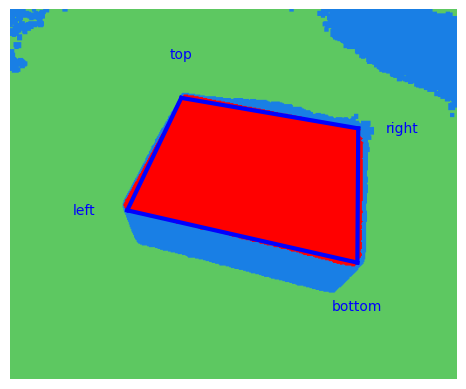

Length of the box is 238.36 and width of the box is 148.56
The height of the box is: 0.74 units.


In [21]:
data = loadmat('example1kinect.mat')
point_cloud2 = data['cloud1']
#Getting floor mask
best_plane, inliers=get_first_mask(0.03,1000,point_cloud2)
# Now visualize the inliers (floor mask)
mask=create_mask(point_cloud2, inliers)
largest_component, best_plane_second=get_second_mask(mask,point_cloud2,0.01,1000)
closed=closed_mask(mask)
corners=find_corners(largest_component)
final_visualization(closed,largest_component,corners,point_cloud2.shape)
length, width,distances= calculate_dimensions(corners)

print('Length of the box is', format(length, '.2f'), 'and width of the box is', format(width, '.2f'))
height_of_box = compute_distance_between_planes(best_plane,best_plane_second)
print(f"The height of the box is: {format(height_of_box, '.2f')} units.")

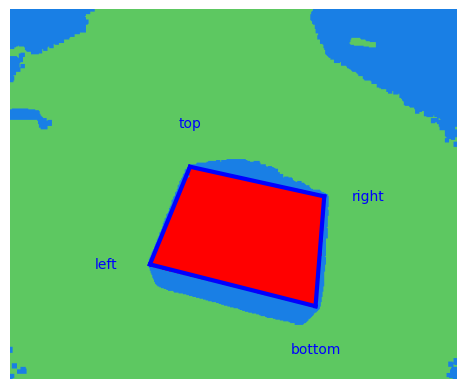

Length of the box is 176.84 and width of the box is 123.74
The height of the box is: 0.98 units.


In [22]:
data = loadmat('example2kinect.mat')
point_cloud2 = data['cloud2']
#Getting floor mask
best_plane, inliers=get_first_mask(0.03,1000,point_cloud2)
# Now visualize the inliers (floor mask)
mask=create_mask(point_cloud2, inliers)
largest_component, best_plane_second=get_second_mask(mask,point_cloud2,0.01,1000)
closed=closed_mask(mask)
corners=find_corners(largest_component)
final_visualization(closed,largest_component,corners,point_cloud2.shape)
length, width,distances= calculate_dimensions(corners)

print('Length of the box is', format(length, '.2f'), 'and width of the box is', format(width, '.2f'))
height_of_box = compute_distance_between_planes(best_plane,best_plane_second)
print(f"The height of the box is: {format(height_of_box, '.2f')} units.")

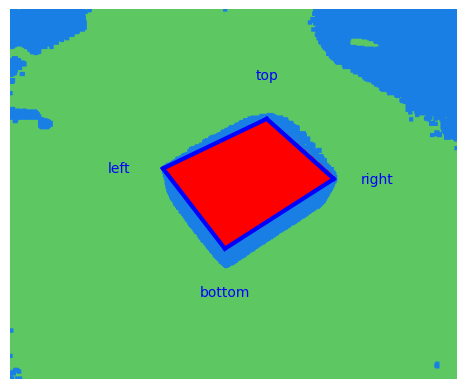

Length of the box is 176.84 and width of the box is 123.74
The height of the box is: 1.06 units.


In [23]:
data = loadmat('example3kinect.mat')
point_cloud2 = data['cloud3']
#Getting floor mask
best_plane, inliers=get_first_mask(0.03,1000,point_cloud2)
# Now visualize the inliers (floor mask)
mask=create_mask(point_cloud2, inliers)
largest_component, best_plane_second=get_second_mask(mask,point_cloud2,0.01,1000)
closed=closed_mask(mask)
corners=find_corners(largest_component)
final_visualization(closed,largest_component,corners,point_cloud2.shape)

print('Length of the box is', format(length, '.2f'), 'and width of the box is', format(width, '.2f'))
height_of_box = compute_distance_between_planes(best_plane,best_plane_second)
print(f"The height of the box is: {format(height_of_box, '.2f')} units.")

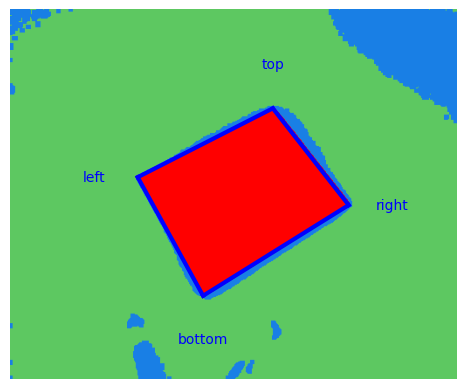

Length of the box is 176.84 and width of the box is 123.74
The height of the box is: 0.92 units.


In [24]:
data = loadmat('example4kinect_corrected.mat')
point_cloud2 = data['cloud4']
#Getting floor mask
best_plane, inliers=get_first_mask(0.03,1000,point_cloud2)
# Now visualize the inliers (floor mask)
mask=create_mask(point_cloud2, inliers)
largest_component, best_plane_second=get_second_mask(mask,point_cloud2,0.01,1000)
closed=closed_mask(mask)
corners=find_corners(largest_component)
final_visualization(closed,largest_component,corners,point_cloud2.shape)

print('Length of the box is', format(length, '.2f'), 'and width of the box is', format(width, '.2f'))
height_of_box = compute_distance_between_planes(best_plane,best_plane_second)
print(f"The height of the box is: {format(height_of_box, '.2f')} units.")